**Table of contents**<a id='toc0_'></a>    
- [Programming Question](#toc1_)    
  - [Preprocessing](#toc1_1_)    
  - [Base model performance](#toc1_2_)    
  - [HyperParameter Exploration](#toc1_3_)    
    - [Different hidden layer sizes and activation functions](#toc1_3_1_)    
      - [Choosing the Layer Size(s) and activation functions to use](#toc1_3_1_1_)    
    - [Exploring Solvers](#toc1_3_2_)    
    - [Learning_rate_init](#toc1_3_3_)    
    - [Exploring Tol](#toc1_3_4_)    
    - [Exploring Alpha](#toc1_3_5_)    
    - [Adam-specific hyperparameters](#toc1_3_6_)    
  - [Evaluating the Chosen Model's Performance](#toc1_4_)    
  - [Conclusion](#toc1_5_)    



# <a id='toc1_'></a>[Programming Question](#toc0_)

_Write a Python program to build a MLP classifier and evaluate your
model’s performance. For this task, you should use the pre-processed
and transformed dataset without feature selection from Task 3.1._


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
import warnings

from sklearn.calibration import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.model_selection import ParameterGrid

In [2]:
# Suppress convergence warnings, outputs got too cluttered with them.
warnings.filterwarnings("ignore", category = UserWarning)

In [3]:
def load_dataset()-> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Uses np.load to load the training and test datasets used for the models in these notebooks.

    Returns:
        tuple: A tuple containing four numpy arrays representing the training and test datasets.
               The tuple elements are as follows:
               - features_train: A numpy array containing the features of the training dataset.
               - targets_train: A numpy array containing the target labels of the training dataset.
               - features_test: A numpy array containing the features of the test dataset.
               - targets_test: A numpy array containing the target labels of the test dataset.
    """    
    # Train dataset
    features_train = np.load("x_train.npy")
    targets_train = np.load("y_train.npy")
    # Test dataset
    features_test = np.load("x_test.npy")
    targets_test = np.load("y_test.npy")
    return features_train, targets_train, features_test, targets_test

In [4]:
features_train, targets_train, features_test, targets_test = load_dataset()
np.shape(features_train), np.shape(features_test)

((16200, 512), (5400, 512))

## <a id='toc1_1_'></a>[Preprocessing](#toc0_)

This is the same process used in task1, but without feature selection. 

Explanations for the pipeline used can be found there.


In [5]:
preprocess_pipeline = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ]) 

In [6]:
features_train = preprocess_pipeline.fit_transform(features_train, targets_train)
features_train

array([[ 1.34805328, -0.51089092, -0.22072501, ...,  0.62005134,
        -0.4428243 , -0.3833698 ],
       [-0.54092637, -0.51089092, -0.22072501, ...,  2.79411635,
        -0.25928421, -0.20709799],
       [ 0.08515136, -0.4425584 , -0.18775652, ..., -0.62388139,
        -0.24371715, -0.3833698 ],
       ...,
       [-0.54092637,  0.28036796, -0.12678161, ...,  0.30081738,
        -0.13987892, -0.3833698 ],
       [-0.54092637, -0.51089092, -0.0347424 , ..., -0.62388139,
        -0.39931725, -0.37945193],
       [-0.200372  , -0.51089092, -0.22072501, ..., -0.58608481,
        -0.07055005, -0.3833698 ]])

In [7]:
features_test = preprocess_pipeline.transform(features_test)
features_test

array([[-0.454214  , -0.51089092, -0.13638068, ...,  3.25211535,
        -0.04748926, -0.3833698 ],
       [-0.54092637, -0.51089092,  0.41589793, ..., -0.33912799,
        -0.19045382,  3.12977599],
       [ 0.64555218,  1.0324676 , -0.22072501, ...,  0.4482971 ,
        -0.53645593, -0.3833698 ],
       ...,
       [-0.54092637, -0.49725863, -0.16874122, ..., -0.62388139,
        -0.05570336, -0.3833698 ],
       [ 7.62056324, -0.51089092, -0.06336407, ...,  0.54101262,
        -0.15137119, -0.3833698 ],
       [ 0.4939653 , -0.34695682, -0.22072501, ..., -0.05794825,
        -0.10298486, -0.3833698 ]])

## <a id='toc1_2_'></a>[Base model performance](#toc0_)

So all results are reproducible, the random_state hyperparameter will be set to 30 for all models. This particular value was chosen randomly and has no meaning. 

In [8]:
mlp = MLPClassifier(random_state=30)
scores = cross_val_score(mlp, features_train, targets_train, cv=10)
scores.mean()

0.9330246913580249

In [9]:
mlp.fit(features_train, targets_train)
predict = mlp.predict(features_test)

In [10]:
print(classification_report(targets_test, predict))

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94       613
         1.0       0.97      0.98      0.97       605
         2.0       0.91      0.93      0.92       628
         3.0       0.86      0.87      0.87       499
         4.0       0.97      0.94      0.95       507
         5.0       0.89      0.91      0.90       409
         6.0       0.86      0.86      0.86       481
         7.0       0.97      0.97      0.97       583
         8.0       0.92      0.89      0.90       511
         9.0       0.99      0.98      0.98       564

    accuracy                           0.93      5400
   macro avg       0.93      0.93      0.93      5400
weighted avg       0.93      0.93      0.93      5400



## <a id='toc1_3_'></a>[HyperParameter Exploration](#toc0_)

For each exploration step, the hyperparameter combinations will be compared based on their cross-validation scores.

When exploring of hyperparameters is complete, the expectation is to create a model that has a higher cross-validation score than the base model shown above.

In [11]:
def mlp_model_cv_score(params: list[dict]) -> list[dict]:
    """Evaluate Multi-Layer Perceptron models with different parameters using cross-validation.

    Args:
        params (list[dict]): A list of dictionaries, each dictionary contains parameters for the MLP model.

    Returns:
        list[dict]: A list of dictionaries, each dictionary contains the parameters and the average cross-validation score for the corresponding model.
    """
    for i in params:
            mlp = MLPClassifier(**i)
            scores = cross_val_score(mlp, features_train, targets_train, cv=10)
            i['score'] = scores.mean()
    return params

In [58]:
def display_scores_line(results: list[dict[str, any]], x_axis: str = 'hidden_layer_sizes', compare: str = 'activation') -> None:
    """Display line plots comparing different settings by cross-validation score.

    Args:
        results (list[dict[str, any]]): A list of dictionaries containing the results data.
        x_axis (str, optional): The variable to be displayed on the x-axis. Defaults to 'hidden_layer_sizes'.
        compare (str, optional): The variable to be compared. Defaults to 'activation'.

    Returns:
        None
    """
    # Extracting data
    comparison_entries = sorted(set(item[f'{compare}'] for item in results))
    x_values = sorted(set(item[f'{x_axis}'] for item in results))  
    scores = {entry: [] for entry in comparison_entries}
    
    for entry in comparison_entries:
        entry_scores = []
        for x_val in x_values:
            matched_items = [item['score'] for item in results if item[f'{compare}'] == entry and item[f'{x_axis}'] == x_val]
            entry_scores.append(matched_items[0] if matched_items else None)  
        scores[entry] = entry_scores

    # Plotting
    plt.figure(figsize=(10, 6))

    for entry in comparison_entries:
        plt.plot(range(len(x_values)), scores[entry], marker='o', label=entry)

    # Set the tick labels 
    plt.xticks(range(len(x_values)), [str(size) for size in x_values], ha='right')

    plt.xlabel(f'{x_axis}')
    plt.ylabel('Scores')
    plt.title(f'Comparing {compare.capitalize()} and {x_axis.capitalize()} Settings by CV Score')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### <a id='toc1_3_1_'></a>[Different hidden layer sizes and activation functions](#toc0_)

The first hyperparameters to be explored will be hidden layer sizes and activation functions. These hyperparameters can be defined as:
* Hidden Layer Sizes:
  * The size of hidden layers in a neural network significantly affects its ability to learn complex patterns from data.
  * Larger hidden layers can capture more intricate features but may lead to overfitting, while smaller ones risk underfitting.
* Activation Functions:
  * Activation functions introduce nonlinearity to neural networks, allowing them to learn and represent complex relationships.
  * Common activation functions include sigmoid, tanh, and ReLU, each are unique.

The aim of exploring different different combinations of hidden layer sizes and activation functions is to find an optimal combination for performance.

In [12]:
params=  {
    'hidden_layer_sizes': [(10,), (25,), (50,), (75,), (100,)], 
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'random_state': [30]
    }
params = list(ParameterGrid(params)) 
params

[{'activation': 'identity', 'hidden_layer_sizes': (10,), 'random_state': 30},
 {'activation': 'identity', 'hidden_layer_sizes': (25,), 'random_state': 30},
 {'activation': 'identity', 'hidden_layer_sizes': (50,), 'random_state': 30},
 {'activation': 'identity', 'hidden_layer_sizes': (75,), 'random_state': 30},
 {'activation': 'identity', 'hidden_layer_sizes': (100,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (10,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (25,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (50,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (75,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'random_state': 30},
 {'activation': 'tanh', 'hidden_layer_sizes': (10,), 'random_state': 30},
 {'activation': 'tanh', 'hidden_layer_sizes': (25,), 'random_state': 30},
 {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'random_state': 3

In [44]:
one_layer_results = mlp_model_cv_score(params)
one_layer_results

[{'activation': 'identity',
  'hidden_layer_sizes': (10,),
  'random_state': 30,
  'score': 0.909753086419753},
 {'activation': 'identity',
  'hidden_layer_sizes': (25,),
  'random_state': 30,
  'score': 0.9089506172839507},
 {'activation': 'identity',
  'hidden_layer_sizes': (50,),
  'random_state': 30,
  'score': 0.9101234567901235},
 {'activation': 'identity',
  'hidden_layer_sizes': (75,),
  'random_state': 30,
  'score': 0.9115432098765434},
 {'activation': 'identity',
  'hidden_layer_sizes': (100,),
  'random_state': 30,
  'score': 0.9108641975308641},
 {'activation': 'logistic',
  'hidden_layer_sizes': (10,),
  'random_state': 30,
  'score': 0.9158641975308642},
 {'activation': 'logistic',
  'hidden_layer_sizes': (25,),
  'random_state': 30,
  'score': 0.9265432098765432},
 {'activation': 'logistic',
  'hidden_layer_sizes': (50,),
  'random_state': 30,
  'score': 0.9312345679012346},
 {'activation': 'logistic',
  'hidden_layer_sizes': (75,),
  'random_state': 30,
  'score': 0.93

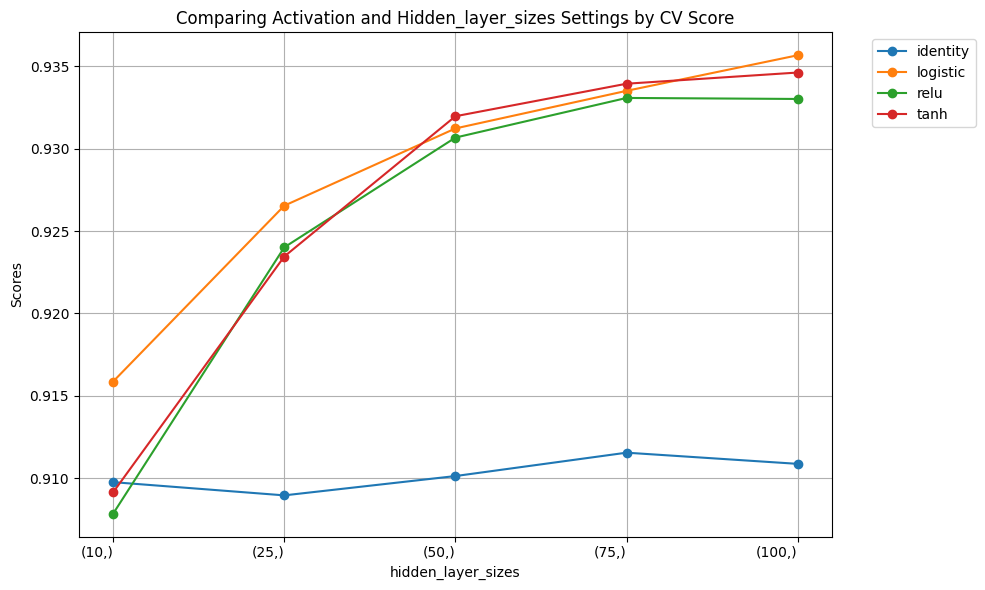

In [60]:
display_scores_line(one_layer_results)

Based on these results, 50-100 is the best performing range of values for one layer. For fine-tuning, more values in this range will be explored. Values past 100 will also be looked at. As there is a clear gap in performance between the identity activation function and other functions, it will no longer be used in further exploration.

In [15]:
params=  {
    'hidden_layer_sizes': [(50,), (60,), (70,), (75,), (80,), (90,), (100,), (125,), (150,)], 
    'activation': ['logistic', 'tanh', 'relu'],
    'random_state': [30]
    }
params = list(ParameterGrid(params)) 
params

[{'activation': 'logistic', 'hidden_layer_sizes': (50,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (60,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (70,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (75,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (80,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (90,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (125,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (150,), 'random_state': 30},
 {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'random_state': 30},
 {'activation': 'tanh', 'hidden_layer_sizes': (60,), 'random_state': 30},
 {'activation': 'tanh', 'hidden_layer_sizes': (70,), 'random_state': 30},
 {'activation': 'tanh', 'hidden_layer_sizes': (75,), 'random_state': 30},

In [16]:
further_one_layer_results = mlp_model_cv_score(params)
further_one_layer_results

[{'activation': 'logistic',
  'hidden_layer_sizes': (50,),
  'random_state': 30,
  'score': 0.9312345679012346},
 {'activation': 'logistic',
  'hidden_layer_sizes': (60,),
  'random_state': 30,
  'score': 0.9337654320987653},
 {'activation': 'logistic',
  'hidden_layer_sizes': (70,),
  'random_state': 30,
  'score': 0.9341975308641975},
 {'activation': 'logistic',
  'hidden_layer_sizes': (75,),
  'random_state': 30,
  'score': 0.9335185185185185},
 {'activation': 'logistic',
  'hidden_layer_sizes': (80,),
  'random_state': 30,
  'score': 0.934567901234568},
 {'activation': 'logistic',
  'hidden_layer_sizes': (90,),
  'random_state': 30,
  'score': 0.9352469135802469},
 {'activation': 'logistic',
  'hidden_layer_sizes': (100,),
  'random_state': 30,
  'score': 0.935679012345679},
 {'activation': 'logistic',
  'hidden_layer_sizes': (125,),
  'random_state': 30,
  'score': 0.9349999999999999},
 {'activation': 'logistic',
  'hidden_layer_sizes': (150,),
  'random_state': 30,
  'score': 0.9

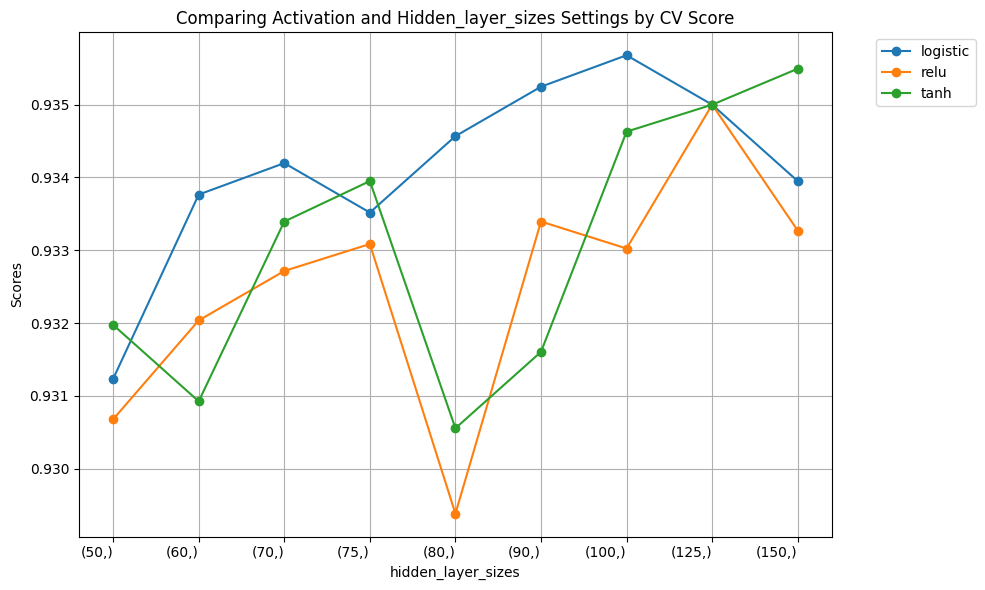

In [63]:
display_scores_line(further_one_layer_results)

Based on these results, the best performing layer size is 100, for the logistic activation function.

For further fine-tuning, increasing the number of hidden layers to two will also be explored. 

In [ ]:
params=  {
    'hidden_layer_sizes': [(10,10), (25,25), (50,50), (75,75), (100,100)], 
    'activation': ['logistic', 'tanh', 'relu'],
    'random_state': [30]
    }
params = list(ParameterGrid(params)) 
params

[{'activation': 'logistic',
  'hidden_layer_sizes': (10, 10),
  'random_state': 30},
 {'activation': 'logistic',
  'hidden_layer_sizes': (25, 25),
  'random_state': 30},
 {'activation': 'logistic',
  'hidden_layer_sizes': (50, 50),
  'random_state': 30},
 {'activation': 'logistic',
  'hidden_layer_sizes': (75, 75),
  'random_state': 30},
 {'activation': 'logistic',
  'hidden_layer_sizes': (100, 100),
  'random_state': 30},
 {'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'random_state': 30},
 {'activation': 'tanh', 'hidden_layer_sizes': (25, 25), 'random_state': 30},
 {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'random_state': 30},
 {'activation': 'tanh', 'hidden_layer_sizes': (75, 75), 'random_state': 30},
 {'activation': 'tanh', 'hidden_layer_sizes': (100, 100), 'random_state': 30},
 {'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'random_state': 30},
 {'activation': 'relu', 'hidden_layer_sizes': (25, 25), 'random_state': 30},
 {'activation': 'relu', 'hidden_

In [ ]:
two_layers_results = mlp_model_cv_score(params)
two_layers_results

[{'activation': 'logistic',
  'hidden_layer_sizes': (10, 10),
  'random_state': 30,
  'score': 0.9037654320987654},
 {'activation': 'logistic',
  'hidden_layer_sizes': (25, 25),
  'random_state': 30,
  'score': 0.9229012345679013},
 {'activation': 'logistic',
  'hidden_layer_sizes': (50, 50),
  'random_state': 30,
  'score': 0.9299382716049382},
 {'activation': 'logistic',
  'hidden_layer_sizes': (75, 75),
  'random_state': 30,
  'score': 0.9346296296296297},
 {'activation': 'logistic',
  'hidden_layer_sizes': (100, 100),
  'random_state': 30,
  'score': 0.9323456790123457},
 {'activation': 'tanh',
  'hidden_layer_sizes': (10, 10),
  'random_state': 30,
  'score': 0.9012345679012347},
 {'activation': 'tanh',
  'hidden_layer_sizes': (25, 25),
  'random_state': 30,
  'score': 0.9209876543209876},
 {'activation': 'tanh',
  'hidden_layer_sizes': (50, 50),
  'random_state': 30,
  'score': 0.9298148148148148},
 {'activation': 'tanh',
  'hidden_layer_sizes': (75, 75),
  'random_state': 30,
  

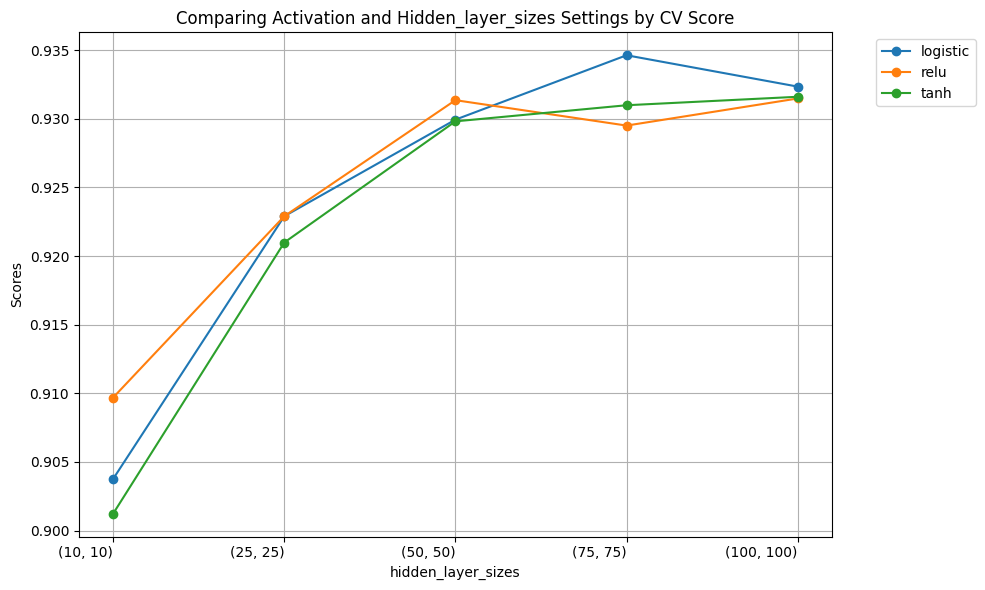

In [65]:
display_scores_line(two_layers_results)

#### <a id='toc1_3_1_1_'></a>[Choosing the Layer Size(s) and activation functions to use](#toc0_)

further_one_layer_results and two_layer_results will be joined to determine the best combination of hyperparameters.

In [25]:
joined_layers_results = np.concatenate([further_one_layer_results, two_layers_results])
# Sort results by score
sorted_results = sorted(joined_layers_results, key=lambda x: x['score'], reverse=True)
print("Top Layer Sizes by Score:")
for idx, param in enumerate(sorted_results[:10], 1):
    print(f"{idx}. Layers: {param['hidden_layer_sizes']}, 'activation' {param['activation']}, Score: {param['score']}")

Top Layer Sizes by Score:
1. Layers: (100,), 'activation' logistic, Score: 0.935679012345679
2. Layers: (150,), 'activation' tanh, Score: 0.9354938271604938
3. Layers: (90,), 'activation' logistic, Score: 0.9352469135802469
4. Layers: (125,), 'activation' logistic, Score: 0.9349999999999999
5. Layers: (125,), 'activation' tanh, Score: 0.9349999999999999
6. Layers: (125,), 'activation' relu, Score: 0.9349999999999999
7. Layers: (100,), 'activation' tanh, Score: 0.9346296296296297
8. Layers: (75, 75), 'activation' logistic, Score: 0.9346296296296297
9. Layers: (80,), 'activation' logistic, Score: 0.934567901234568
10. Layers: (70,), 'activation' logistic, Score: 0.9341975308641975


Based on these results, the activation function logistic with the layer size of (100,) will be used. This is the configuration that has produced the highest CV score out of all layer sizes explored.

### <a id='toc1_3_2_'></a>[Exploring Solvers](#toc0_)

In MLPs, solvers are optimisation algorithms for neural networks.Solvers impact the efficiency and effectiveness of model training. By exploring the results of different solvers, the most suitable optimisation algorithm for the model can be determined, with the aim of finding the one that provides the best performance. 

In [27]:
params=  {
    'hidden_layer_sizes': [(100,)], 
    'activation': ['logistic'],
    'random_state': [30],
    'solver': ['lbfgs', 'sgd', 'adam'],}
params = list(ParameterGrid(params)) 
params

[{'activation': 'logistic',
  'hidden_layer_sizes': (100,),
  'random_state': 30,
  'solver': 'lbfgs'},
 {'activation': 'logistic',
  'hidden_layer_sizes': (100,),
  'random_state': 30,
  'solver': 'sgd'},
 {'activation': 'logistic',
  'hidden_layer_sizes': (100,),
  'random_state': 30,
  'solver': 'adam'}]

In [28]:
solver_results = mlp_model_cv_score(params)
solver_results

[{'activation': 'logistic',
  'hidden_layer_sizes': (100,),
  'random_state': 30,
  'solver': 'lbfgs',
  'score': 0.9238888888888889},
 {'activation': 'logistic',
  'hidden_layer_sizes': (100,),
  'random_state': 30,
  'solver': 'sgd',
  'score': 0.9283950617283951},
 {'activation': 'logistic',
  'hidden_layer_sizes': (100,),
  'random_state': 30,
  'solver': 'adam',
  'score': 0.935679012345679}]

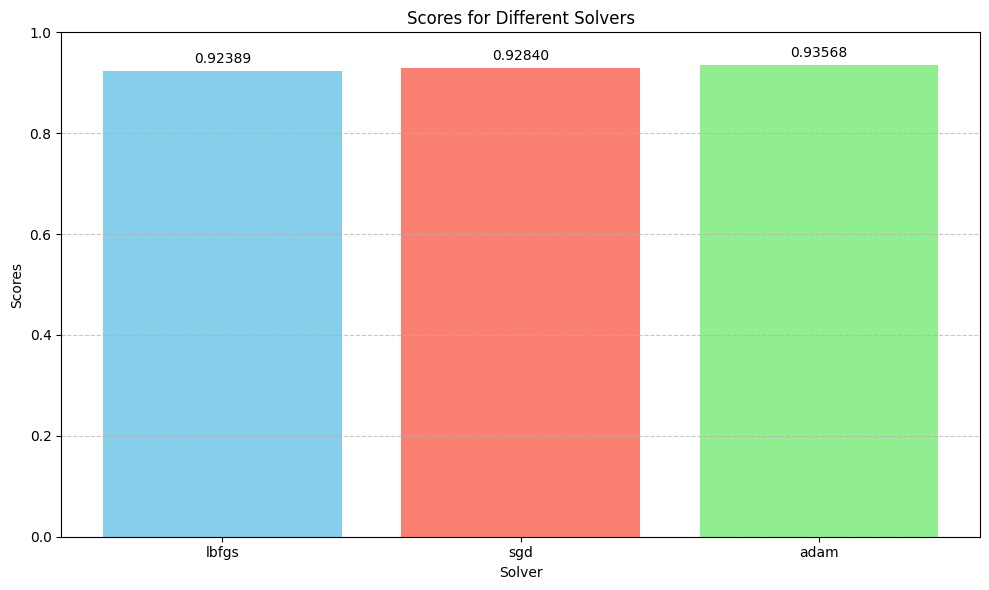

In [66]:
# Extracting data
solvers = [item['solver'] for item in solver_results]
scores = [item['score'] for item in solver_results]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(solvers, scores, color=['skyblue', 'salmon', 'lightgreen'])

# Add labels to bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.5f}', ha='center', va='bottom')

plt.xlabel('Solver')
plt.ylabel('Scores')
plt.title('Scores for Different Solvers')
plt.ylim(0, 1)  # Set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


These results show that adam is the strongest performing solver. Therefore, it will be the solver used going forward.

### <a id='toc1_3_3_'></a>[Learning_rate_init](#toc0_)

Next, learning_rate_init will be explored. This is the initial learning rate used. The aim of this exploration is to potentially improve results by finding an optimal value. 

In [35]:
params=  {
    'hidden_layer_sizes': [(100,)], 
    'activation': ['logistic'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01, 0.1, 1]
          }
params = list(ParameterGrid(params)) 

In [36]:
lr_results = mlp_model_cv_score(params)
lr_results

[{'activation': 'logistic',
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'solver': 'adam',
  'score': 0.9337654320987653},
 {'activation': 'logistic',
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.01,
  'solver': 'adam',
  'score': 0.9254938271604939},
 {'activation': 'logistic',
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.1,
  'solver': 'adam',
  'score': 0.8861111111111111},
 {'activation': 'logistic',
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 1,
  'solver': 'adam',
  'score': 0.8115432098765432}]

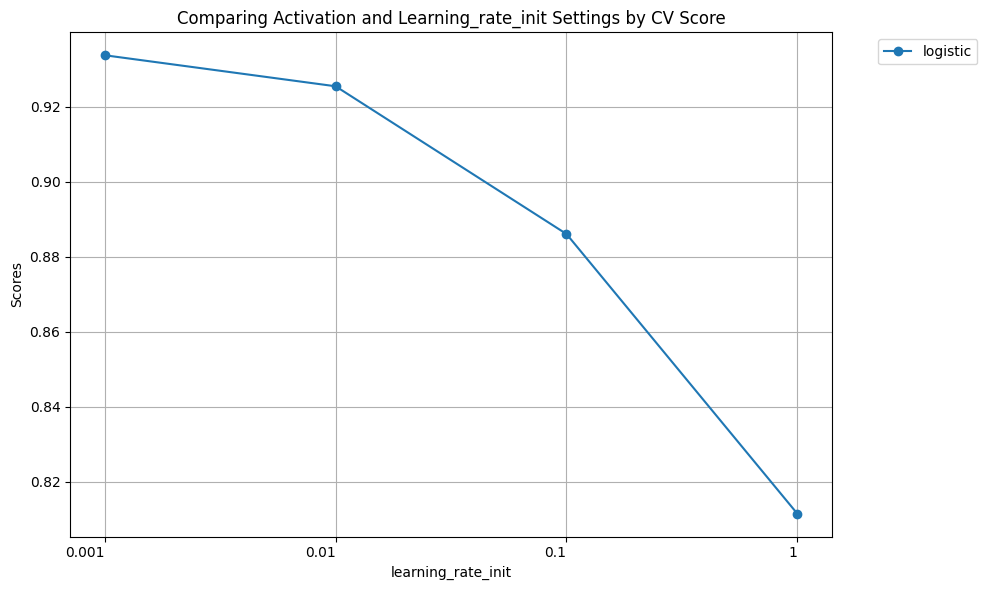

In [67]:
display_scores_line(lr_results, x_axis = 'learning_rate_init')

Based on these results, a learning rate of 0.001 will be used going forward.

### <a id='toc1_3_4_'></a>[Exploring Tol](#toc0_)

This parameter affects the tolerance for the optimisation, determining the stopping criterion. Finding an optimal value for this could result in faster convergence to optimal solutions, stopping iterations when improvements become minimal, and help prevent overfitting. 

In [46]:
params = {
    'hidden_layer_sizes': [(100,)],
    'activation': ['logistic'],
    'random_state': [30],
    'solver': ['adam'],
    'learning_rate_init': [0.001],
    'tol': [1e-4, 1e-5, 1e-6],
}
params = list(ParameterGrid(params))
params

[{'activation': 'logistic',
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001},
 {'activation': 'logistic',
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05},
 {'activation': 'logistic',
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-06}]

In [70]:
tol_results = mlp_model_cv_score(params)
tol_results

[{'activation': 'logistic',
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001,
  'score': 0.935679012345679},
 {'activation': 'logistic',
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05,
  'score': 0.935679012345679},
 {'activation': 'logistic',
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-06,
  'score': 0.9335802469135803}]

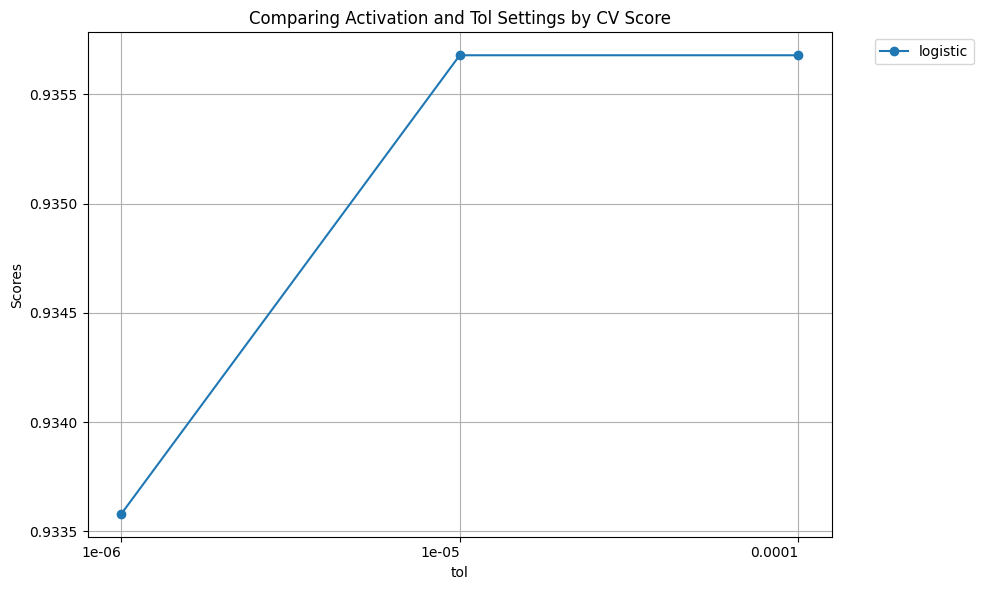

In [69]:
display_scores_line(tol_results, x_axis = 'tol')

There is no difference in scores between the 2 best performing tol settings. 1e-5 will be used (chosen at random out of the 2 best performing values). 

### <a id='toc1_3_5_'></a>[Exploring Alpha](#toc0_)

Alpha will now be explored.  This value helps prevent overfitting by adding an L2 regularization term to the loss function, which discourages overly complex models. Setting an appropriate alpha value can help improve model performance by balancing between fitting the training data and limiting overfitting.

In [13]:
params = {
    'hidden_layer_sizes': [(100,)],
    'activation': ['logistic'],
    'random_state': [30],
    'solver': ['adam'],
    'learning_rate_init': [0.001],
    'tol': [1e-5],
    'alpha': [0.0001, 0.001, 0.01],
}
params = list(ParameterGrid(params))
params

[{'activation': 'logistic',
  'alpha': 0.0001,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05},
 {'activation': 'logistic',
  'alpha': 0.001,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05},
 {'activation': 'logistic',
  'alpha': 0.01,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05}]

In [14]:
alpha_results = mlp_model_cv_score(params)
alpha_results

[{'activation': 'logistic',
  'alpha': 0.0001,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05,
  'score': 0.935679012345679},
 {'activation': 'logistic',
  'alpha': 0.001,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05,
  'score': 0.9337654320987655},
 {'activation': 'logistic',
  'alpha': 0.01,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05,
  'score': 0.9351234567901233}]

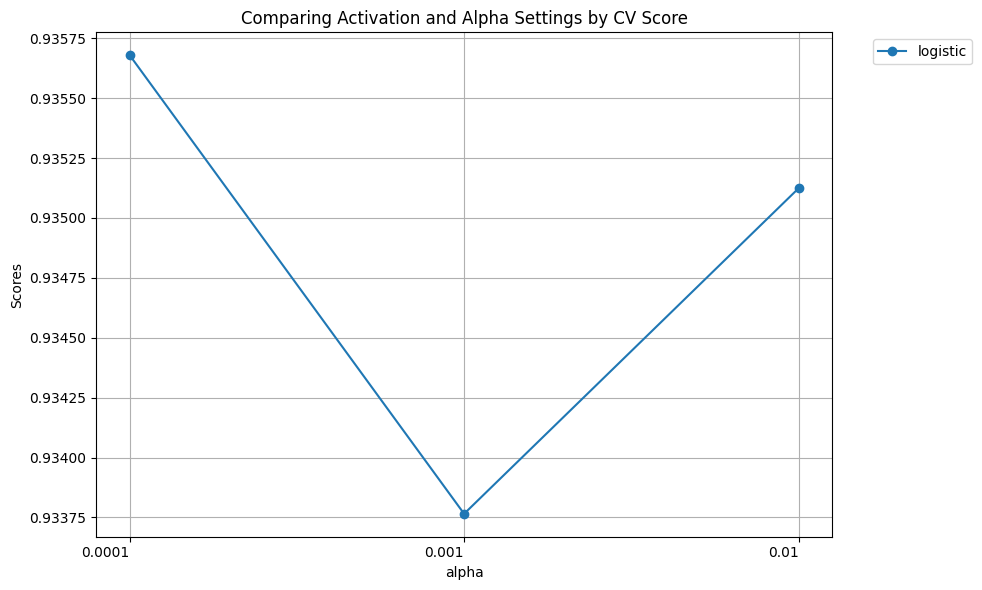

In [72]:
display_scores_line(alpha_results, x_axis = 'alpha')

Based on these results, 0.0001 will be the value of alpha used.

### <a id='toc1_3_6_'></a>[Adam-specific hyperparameters](#toc0_)

The next hyperparameters to be explored are specific to the 'adam' solver. These are:
* beta_1 (β₁) 
* beta_2 (β₁) 
* epsilon

These hyperparameters are key to the Adam optimisation solver, and influence it's behaviour during the optimisation process. The aim of exploring these values is to improve the Adam solver's performance, and therefore the model's performance.

In [16]:
params = {
    'hidden_layer_sizes': [(100,)],
    'activation': ['logistic'],
    'random_state': [30],
    'solver': ['adam'],
    'learning_rate_init': [0.001],
    'tol': [1e-5],
    'alpha': [0.0001],
    'beta_1': [0.9, 0.95, 0.99],
}
params = list(ParameterGrid(params))
params

[{'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.9,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05},
 {'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.95,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05},
 {'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.99,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05}]

In [17]:
beta1_results = mlp_model_cv_score(params)
beta1_results

[{'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.9,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05,
  'score': 0.935679012345679},
 {'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.95,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05,
  'score': 0.9351234567901235},
 {'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.99,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05,
  'score': 0.9343827160493827}]

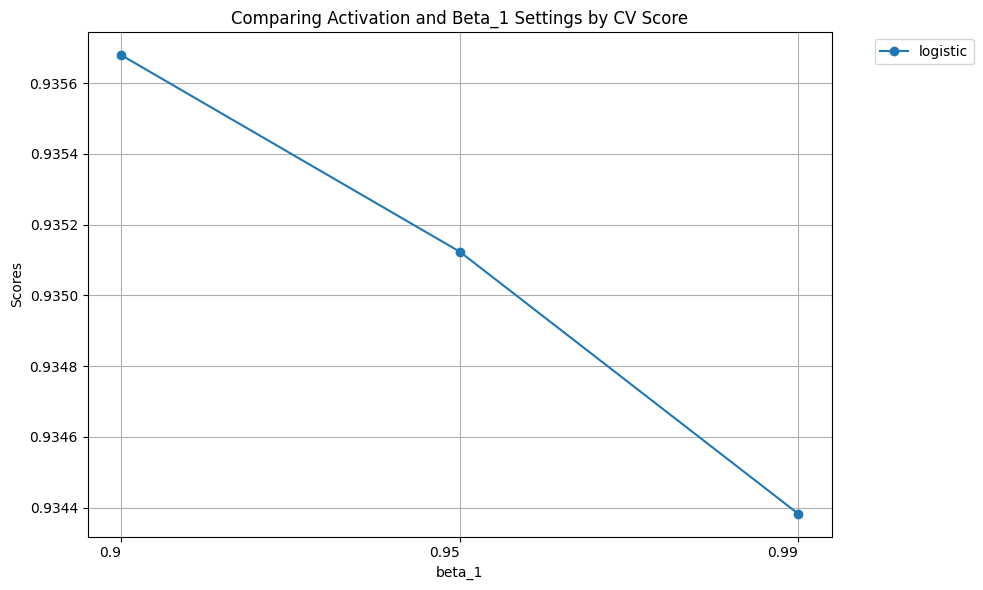

In [76]:
display_scores_line(beta1_results, x_axis = 'beta_1')

Based on these results, the value for beta_1 that performs best is 0.9.

In [20]:
params = {
    'hidden_layer_sizes': [(100,)],
    'activation': ['logistic'],
    'random_state': [30],
    'solver': ['adam'],
    'learning_rate_init': [0.001],
    'tol': [1e-5],
    'alpha': [0.0001],
    'beta_1': [0.9],
    'beta_2': [0.999, 0.99, 0.95],
}
params = list(ParameterGrid(params))
params

[{'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.9,
  'beta_2': 0.999,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05},
 {'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.9,
  'beta_2': 0.99,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05},
 {'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.9,
  'beta_2': 0.95,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05}]

In [21]:
beta2_results = mlp_model_cv_score(params)
beta2_results

[{'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.9,
  'beta_2': 0.999,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05,
  'score': 0.935679012345679},
 {'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.9,
  'beta_2': 0.99,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05,
  'score': 0.9337037037037037},
 {'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.9,
  'beta_2': 0.95,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05,
  'score': 0.9335185185185185}]

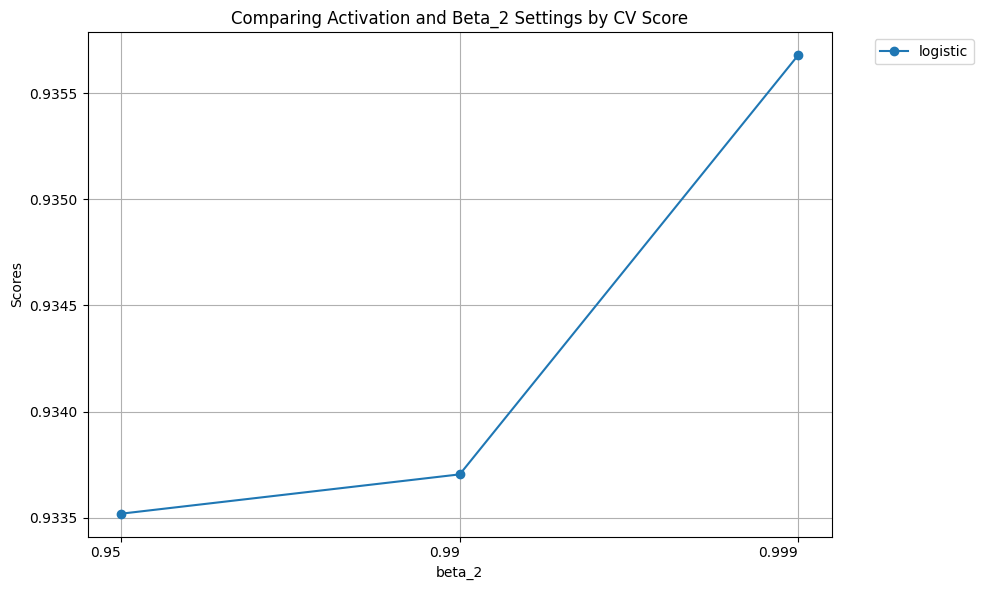

In [78]:
display_scores_line(beta2_results, x_axis = 'beta_2')

Based on these results, the value for beta_2 that performs best is 0.999.

In [93]:
params = {
    'hidden_layer_sizes': [(100,)],
    'activation': ['logistic'],
    'random_state': [30],
    'solver': ['adam'],
    'learning_rate_init': [0.001],
    'tol': [1e-5],
    'alpha': [0.0001],
    'beta_1': [0.9],
    'beta_2': [0.95],
    'epsilon': [1e-7, 1e-8, 1e-9]
}
params = list(ParameterGrid(params))
params

[{'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.9,
  'beta_2': 0.95,
  'epsilon': 1e-07,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05},
 {'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.9,
  'beta_2': 0.95,
  'epsilon': 1e-08,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05},
 {'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.9,
  'beta_2': 0.95,
  'epsilon': 1e-09,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05}]

In [94]:
eps_results = mlp_model_cv_score(params)
eps_results

[{'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.9,
  'beta_2': 0.95,
  'epsilon': 1e-07,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05,
  'score': 0.9335185185185185},
 {'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.9,
  'beta_2': 0.95,
  'epsilon': 1e-08,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05,
  'score': 0.9335185185185185},
 {'activation': 'logistic',
  'alpha': 0.0001,
  'beta_1': 0.9,
  'beta_2': 0.95,
  'epsilon': 1e-09,
  'hidden_layer_sizes': (100,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05,
  'score': 0.9332098765432096}]

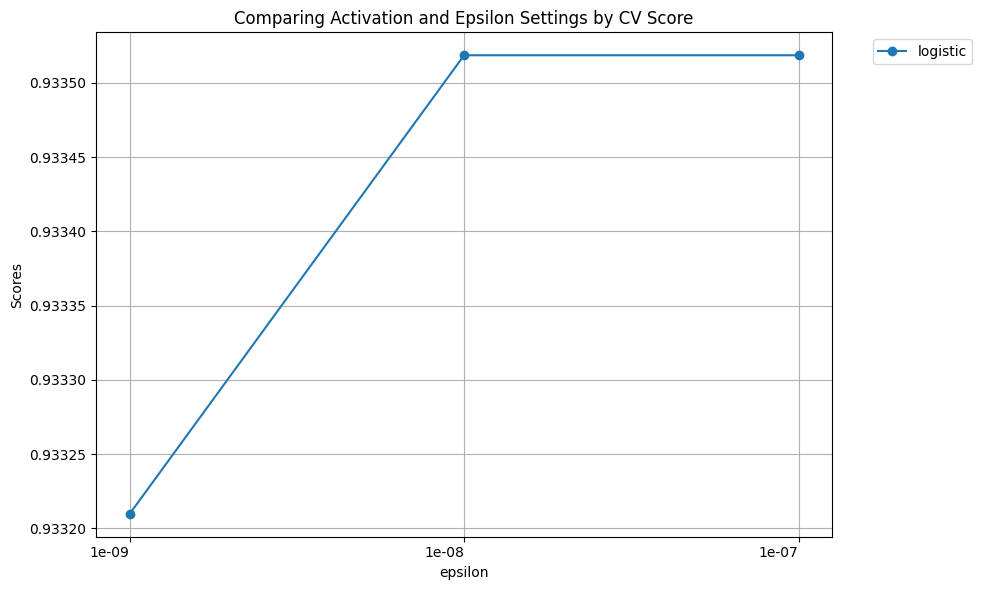

In [95]:
display_scores_line(eps_results, x_axis = 'epsilon')

Based on these results, the value for epsilon that performs best is 1e-07

No further hyperparameter exploration will be performed, due to time constraints. The combination of parameters reached from the exploration has a very strong cross-validation score. 

Further explorations could involve:
* More layer size exploration
* Exploring the hyperparameters specific to other solvers, like learning_rate for the sgd solver.


In [96]:
final_results = eps_results
best_params = max(final_results, key=lambda x: x['score'])
best_params

{'activation': 'logistic',
 'alpha': 0.0001,
 'beta_1': 0.9,
 'beta_2': 0.95,
 'epsilon': 1e-07,
 'hidden_layer_sizes': (100,),
 'learning_rate_init': 0.001,
 'random_state': 30,
 'solver': 'adam',
 'tol': 1e-05,
 'score': 0.9335185185185185}

In [97]:
best_params_cv_score = best_params.pop('score')
best_params_cv_score

0.9335185185185185

In [98]:
#Train final model with best hyperparameters
best_model = MLPClassifier(**best_params)
best_params['score'] = best_params_cv_score
best_model.fit(features_train, targets_train)

MLPClassifier(activation='logistic', beta_2=0.95, epsilon=1e-07,
              random_state=30, tol=1e-05)

In [99]:
model_filename = 'task2_mlp.pkl'
# Save the model to a file using pickle
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

In [100]:
# Load the model from the file using pickle
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
final_mlp = loaded_model

## <a id='toc1_4_'></a>[Evaluating the Chosen Model's Performance](#toc0_)

In [101]:
predict = final_mlp.predict(features_test)

In [102]:
print("Classification Report:")
print(classification_report(targets_test, predict))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       613
         1.0       0.98      0.97      0.97       605
         2.0       0.89      0.94      0.92       628
         3.0       0.86      0.84      0.85       499
         4.0       0.96      0.94      0.95       507
         5.0       0.91      0.91      0.91       409
         6.0       0.86      0.85      0.85       481
         7.0       0.98      0.98      0.98       583
         8.0       0.90      0.90      0.90       511
         9.0       0.98      0.98      0.98       564

    accuracy                           0.93      5400
   macro avg       0.93      0.92      0.92      5400
weighted avg       0.93      0.93      0.93      5400



Based on these results, it can be said:
* The precision, recall, and F1-score stay relatively stable across different classes, this suggests consistent performance across all classes. However, the model has some classes that perform better than others (around scores of 0.98 for 9.0 vs around 0.85 for 3.0) 
* The accuracy of the model is 0.93. This is high.
* Overall, the model performs well for all classes, with an accuracy of 0.93 leaving a slight room for improvement. Further hyperparameter exploration and fine-tuning could be performed to improve the model's performance, but it is not as necessary for this model due to the high performance. An MLP classifier appears to be very well suited to this dataset. Due to the slight increase in performance, the exploration of hyperparameters can be considered somewhat successful.

Next, some visualisations of performance will be displayed. These are a confusion matrix, a precision-recall curve and a ROC curve.

A confusion matrix is a table that is often used to describe the performance of a classification model. It assists in visualisation of the performance of a model. Elements on the diagonal represent correct predictions for each class, while off-diagonal elements represent misclassifications.

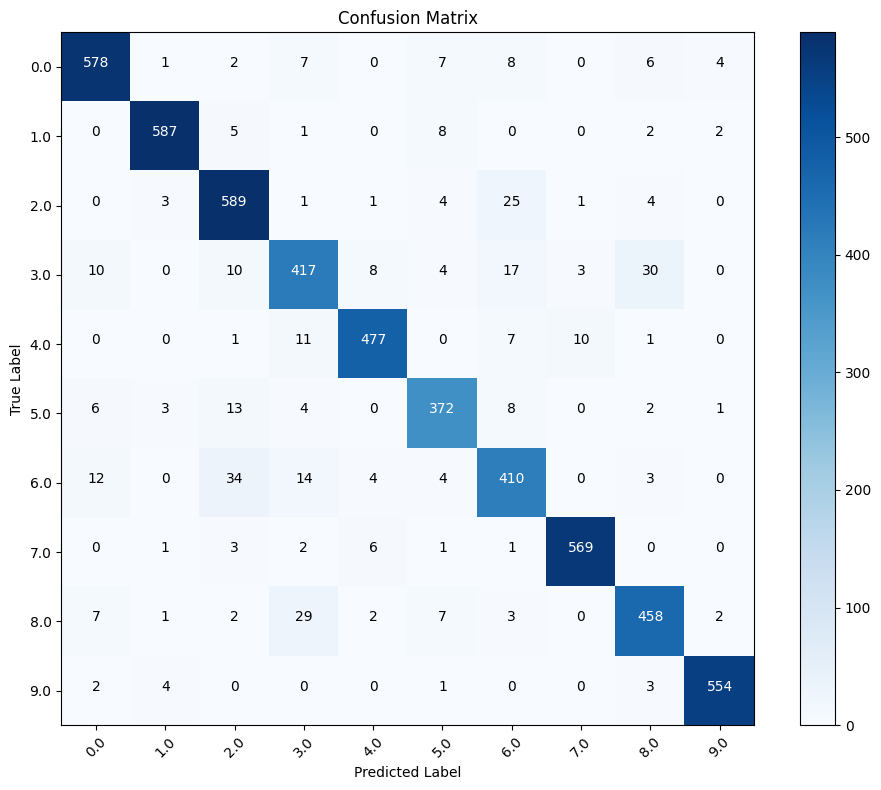

In [103]:
# Create the CM

# Get the unique class labels
classes = np.unique(targets_test)

# Confusion Matrix
cm = confusion_matrix(targets_test, predict)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

A precision-recall curve is a plot of the precision and recall for different classes in a classification model. This visualises the trade-off between precision and recall, indicating the model's performance. A higher area under the precision-recall curve (AUC-PR) indicates better overall performance of the model.

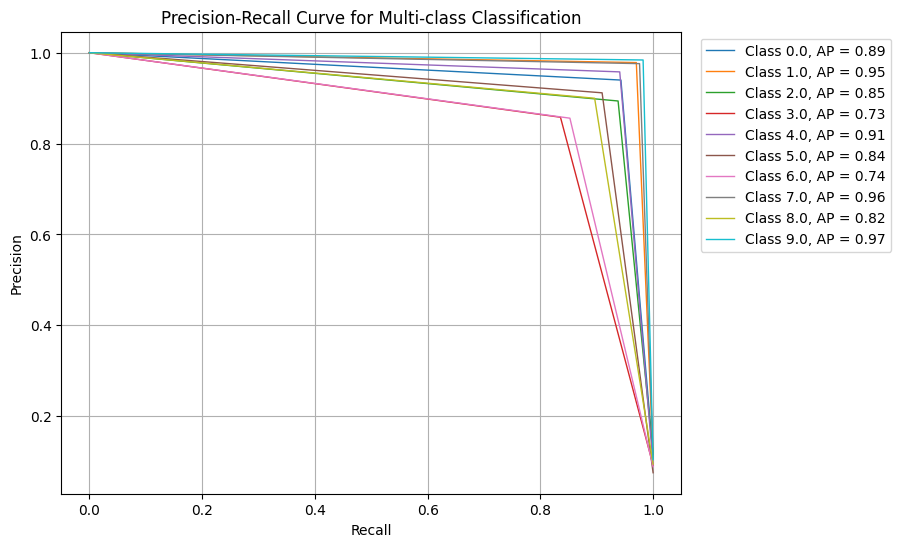

In [104]:
# Create p-r curve

classes = np.unique(targets_test)

# Initialise arrays to store precision and recall values for each class
precision = dict()
recall = dict()
average_precision = dict()  # Store average precision scores for each class

# Calculate precision and recall for each class
for cls in classes:
    # Binarise the targets for the current class
    targets_bin = np.where(targets_test == cls, 1, 0)
    targets_pred_bin = np.where(predict == cls, 1, 0)
    
    # Calculate precision, recall, and average precision
    precision[cls], recall[cls], _ = precision_recall_curve(targets_bin, targets_pred_bin)
    average_precision[cls] = average_precision_score(targets_bin, targets_pred_bin)

# Plot Precision-Recall Curve for each class
plt.figure(figsize=(8, 6))
for cls in classes:
    plt.plot(recall[cls], precision[cls], lw=1, label=f'Class {cls}, AP = {average_precision[cls]:.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-class Classification')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.grid(True)
plt.show()

The ROC curve is a plot that shows the true positive rate against the false positive rate for different classes. A higher AUC-ROC value indicates better overall performance of the model in distinguishing between the two classes.

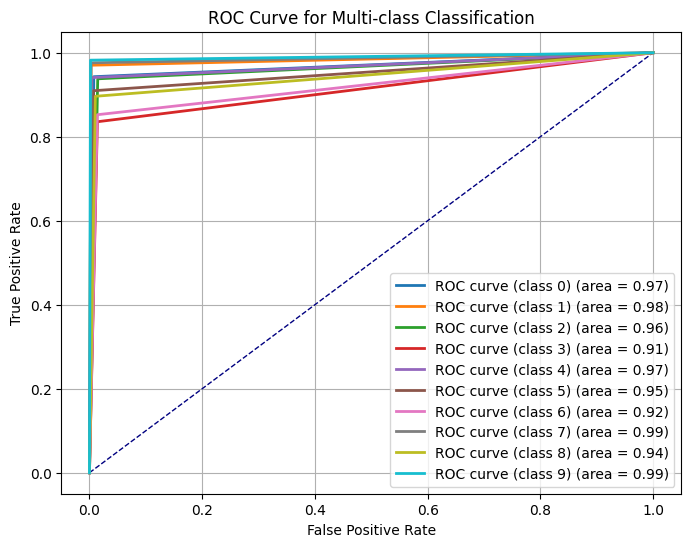

In [105]:
# Create the ROC curve

# Binarise the target variables
targets_bin = label_binarize(targets_test, classes=np.unique(targets_test))
targets_pred_bin = label_binarize(predict, classes=np.unique(targets_test))

# Determine the number of classes
n_classes = targets_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targets_bin[:, i], targets_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(targets_bin.ravel(), targets_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], color='navy', lw = 1, linestyle='--')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw = 2, label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend()
plt.grid(True)
plt.show()

## <a id='toc1_5_'></a>[Conclusion](#toc0_)

After applying appropriate pre-processing techniques, as well as hyperparameter exploration with comparisons of hyperparameter combinations using CV scores, an MLP classifier was created. This classifier very slightly outperforms the base model provided on sci-kit learn (CV score of 0.9330 versus 0.9335). Results have been visualised and discussed. Suggestions for further hyperparameter exploration were provided.  